# Test Envoiriment for the  functions in the module

[How To Use Conda Environment In a Jupyter Notebook
](https://saturncloud.io/blog/how-to-use-conda-environment-in-a-jupyter-notebook/#:~:text=Using%20a%20Conda%20Environment%20in%20Jupyter%20Notebook&text=This%20package%20allows%20you%20to,be%20used%20in%20Jupyter%20Notebook.&text=This%20will%20create%20a%20new%20kernel%20for%20the%20“myenv”%20environment,be%20used%20in%20Jupyter%20Notebook.)

## Train

In [ ]:
#!python main.py --model --datasetpath --state "train" --pretrained_path --output_path

## Teste de funções de érda que serão utilizadas

In [ ]:
from loss import *
from Metrics import *
from torch.nn.functional import mse_loss
from kornia.losses import ssim_loss
from numpy import mean 
from time import time
import lpips

class ssim_1(nn.Module):
    def __init__(self, window_size):
        super(ssim_1,self).__init__()
        self.window_size = window_size
    def forward(self, input, target):
        return ssim_loss(input, target, self.window_size)

class mse_1(nn.Module):
    def __init__(self):
        super(mse_1,self).__init__()

    def forward(self, input, target):
        return mse_loss(input, target)

gt_image = torch.randn(1, 3, 64, 64, requires_grad=True).to(torch.float)
t_image = torch.randn(1, 3, 64, 64, requires_grad=True).to(torch.float)
mean_val = mean(t_image.detach().numpy())

# Example usage of the Dark Channel Prior loss function
#find patch size
patch_size = 3
print(mean)
losses = {
    "DarkChannelPriorLoss": DarkChannelPriorLoss(patch_size),
    "L_exp": L_exp(patch_size,mean_val),
    "L_color": L_color(),
    "mse_loss":mse_1(),
    "light_loss": light_loss(),
    "color_loss": color_loss(),
    "L1Loss": L1Loss(),
    "SSIM loss":ssim_1(window_size=11),
    "lch_loss": lch_Loss(),
    "lab_loss": lab_Loss(),
    "loss_fn_alex" : lpips.LPIPS(net='alex'), # best forward scores
    "loss_fn_vgg" : lpips.LPIPS(net='vgg'), # closer to "traditional" perceptual loss, when used for optimization
    "loss_squeeze" : lpips.LPIPS(net='squeeze') # lightest, faster, narrower, lower quality
}

for name, loss in losses.items():
    start_time = time()
    if name== "loss_fn_vgg" or name == "loss_squeeze" or name == "loss_fn_alex" or name == "L1Loss" or name == "light_loss" or name == "color_loss" or name == "SSIM loss" or name == "color_loss" or name == "mse_loss" or name == "lab_loss" or name == "lch_loss":
        loss = loss(gt_image, t_image)
    else:
        
        loss = loss(t_image)
    end_time = time()
    print(name, ":", loss.item(), "// Time:", end_time-start_time)


-0.009181792847812176


In [1]:
from loss import *
from Metrics import *
from torch.nn.functional import mse_loss
from kornia.losses import ssim_loss
from src.train import load_data, load_data_test
from src.split_data import load_image_paths
from numpy import mean, round, transpose
from time import time
import lpips

class ssim_1(nn.Module):
    def __init__(self, window_size):
        super(ssim_1,self).__init__()
        self.window_size = window_size
    def forward(self, input, target):
        return ssim_loss(input, target, self.window_size)

class mse_1(nn.Module):
    def __init__(self):
        super(mse_1,self).__init__()

    def forward(self, input, target):
        return mse_loss(input, target)

# Exemplo de uso:
datapath_train,datapath_test = load_image_paths(dataset_path="data/UDWdata/",dataset="all")
#train_loader=load_data(datapath_train, datapath_train)
test_loader = load_data(datapath_test,datapath_test)
# Suponha que você tenha um DataLoader chamado 'train_loader' com batch_size=4


#gt_image = torch.randn(1, 3, 64, 64, requires_grad=True)
#t_image = torch.randn(1, 3, 64, 64, requires_grad=True)

#mean_val = mean(t_image.detach().numpy())

# Example usage of the Dark Channel Prior loss function
#find patch size
patch_size = 5 #tenho que saber como colocar esse pararmero no codigo das loss E o parametro das medias tbm
#print(mean)
"""losses = {
    "DarkChannelPriorLoss": DarkChannelPriorLoss(patch_size),
    "L_exp": L_exp(patch_size,mean_val),
    "L_color": L_color(),
    "mse_loss":mse_1(),
    "light_loss": light_loss2(),
    "color_loss": color_loss2(),
    "L1Loss": L1Loss(),
    "SSIM loss":ssim_1(window_size=11),
    "lch_loss": lch_Loss(),
    "lab_loss": lab_Loss(),
    "loss_fn_alex" : lpips.LPIPS(net='alex'), # best forward scores
    "loss_fn_vgg" : lpips.LPIPS(net='vgg'), # closer to "traditional" perceptual loss, when used for optimization
    "loss_squeeze" : lpips.LPIPS(net='squeeze') # lightest, faster, narrower, lower quality
}"""
for batch_idx, (t_image, gt_image, data_color, data_blur) in enumerate(test_loader):
    if batch_idx >= 2:
        break
            # Plotagem das imagens
            #Convertendo tensores para NumPy arrays para plotagem
    gt_image = gt_image.unsqueeze(0).to(torch.float)+1 /2#devo obrigatoriamente converter as imagens para o tipo float
    t_image = t_image.unsqueeze(0).to(torch.float)

    print(gt_image.shape, t_image.shape)

    #print("gt_image: ",gt_image.shape,"t_image: ", t_image.shape, "/n")
    mean_val = mean(t_image.detach().numpy())
    losses = {
    "mse_loss":mse_1(),#
    "light_loss": light_loss(),#
    "color_loss": color_loss(),#
    "SSIM loss":ssim_1(window_size=11),#
    "DarkChannelPriorLoss": DarkChannelPriorLoss(patch_size),
    "L1Loss": L1Loss(),
    "lch_loss": lch_Loss(),
    "lab_loss": lab_Loss(),
    #"L_exp": L_exp(patch_size,mean_val),
    "L_color": L_color(),
    "loss_fn_alex" : lpips.LPIPS(net='alex'), # best forward scores#
    "loss_fn_vgg" : lpips.LPIPS(net='vgg'), # closer to "traditional" perceptual loss, when used for optimization#
    "loss_squeeze" : lpips.LPIPS(net='squeeze') # lightest, faster, narrower, lower quality#
}
    #image_low = transpose(data_low.detach().cpu().numpy(), (1, 2, 0))
    #image_high = transpose(data_high.detach().cpu().numpy(), (1, 2, 0))
    for name, loss in losses.items():
        start_time = time()
        if name== "loss_fn_vgg" or name == "loss_squeeze" or name == "loss_fn_alex" or name == "L1Loss" or name == "light_loss" or name == "color_loss" or name == "SSIM loss" or name == "color_loss" or name == "mse_loss" or name == "lab_loss" or name == "lch_loss":
            loss = loss(gt_image, t_image)
        else:
            loss = loss(t_image)
        end_time = time()
        print(name, ":", loss.item(), "// Time:", round(end_time-start_time,6))
    print(f"\n  Teste numero: {batch_idx + 1} \n")


Total training examples: 1226
torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]
Loading model from: /home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/lpips/weights/v0.1/squeeze.pth
mse_loss : 1.006898045539856 // Time: 0.000225
light_loss : 0.9469518065452576 // Time: 0.00031
color_loss : 1.1969971656799316 // Time: 0.003511
SSIM loss : 0.6007818579673767 // Time: 0.005193
DarkChannelPriorLoss : -0.7234584093093872 // Time: 0.000279
L1Loss : 0.8827491402626038 // Time: 0.000392
lch_loss : 121.24275207519531 // Time: 0.008348
lab_loss : 452755.15625 // Time: 0.128029
L_color : 0.3486155867576599 // Time: 0.000394
loss_fn_alex : 0.8487111926078796 // Time: 0.024187


/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loss_fn_vgg : 0.9050040245056152 // Time: 0.234936
loss_squeeze : 0.726405918598175 // Time: 0.022504

  Teste numero: 1 

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]
Loading model from: /home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/lpips/weights/v0.1/squeeze.pth
mse_loss : 0.9694082140922546 // Time: 0.000185
light_loss : 1.0050922632217407 // Time: 0.00036
color_loss : 1.3178290128707886 // Time: 0.000798
SSIM loss : 0.5402056574821472 // Time: 0.003896
DarkChannelPriorLoss : -0.7244083285331726 // Time: 0.000196
L1Loss

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from loss.ptcolor import rgb2lab #pegar no codigo original
from loss.Qnt import quantAB,quantL
from time import time

# # Função fictícia para converter RGB para LAB
# def rgb2lab(rgb):
#     # Implementação simplificada de conversão (apenas para ilustração)
#     return rgb * 100  # Fictício: escalar para simular a conversão

# # Função fictícia para quantização de AB
# def quantAB(levels, vmin, vmax):
#     return torch.linspace(vmin, vmax, levels).view(1, levels, 1, 1).expand(1, levels, 2, 1)

class lab_Loss(nn.Module):
    def __init__(self, alpha=1, weight=1, levels=7, vmin=-80, vmax=80):
        super(lab_Loss, self).__init__()
        self.alpha = alpha
        self.weight = weight
        self.levels = levels
        self.vmin = vmin
        self.vmax = vmax

    def Hist_2_Dist_L(self, img, tab, alpha):
        img_dist = ((img.unsqueeze(1) - tab) ** 2)
        p = F.softmax(-alpha * img_dist, dim=1)
        print("hist_l ",p)
        return p

    def Hist_2_Dist_AB(self, img, tab, alpha):
        img_dist = ((img.unsqueeze(1) - tab) ** 2).sum(2)
        p = F.softmax(-alpha * img_dist, dim=1)
        print("hist_ab ",p.shape)
        return p

    def loss_ab(self, img, gt, alpha, tab, levels):
        p = self.Hist_2_Dist_AB(img, tab, alpha).cuda()
        q = self.Hist_2_Dist_AB(gt, tab, alpha).cuda()
        p = torch.clamp(p, 0.001, 0.999)
        loss = -(q * torch.log(p)).sum([1, 2, 3]).mean()
        print("loss ab:", loss)
        return loss

    def forward(self, img, gt):
        tab = quantAB(self.levels, self.vmin, self.vmax).cuda()
        lab_img = torch.clamp(rgb2lab(img.cuda()), self.vmin, self.vmax).cuda()
        lab_gt = torch.clamp(rgb2lab(gt), self.vmin, self.vmax).cuda()
        loss_l = torch.abs(lab_img[:, 0, :, :] - lab_gt[:, 0, :, :]).mean()
        loss_AB = self.loss_ab(lab_img[:, 1:, :, :], lab_gt[:, 1:, :, :], self.alpha, tab, self.levels)
        loss = loss_l + self.weight * loss_AB
        #print("loss: ",loss)
        return loss

# Função ajustada para comparar
class lab_Loss_Adjusted(nn.Module):
    def __init__(self, alpha=1, weight=1, levels=7, vmin=-80, vmax=80):
        super(lab_Loss_Adjusted, self).__init__()
        self.alpha = alpha
        self.weight = weight
        self.levels = levels
        self.vmin = vmin
        self.vmax = vmax

    def Hist_2_Dist_L(self, img, tab, alpha):
        img_dist = ((img.unsqueeze(1) - tab) ** 2)
        p = F.softmax(-alpha * img_dist, dim=1)
        return p

    def Hist_2_Dist_AB(self, img, tab, alpha):
        img_dist = ((img.unsqueeze(1) - tab) ** 2).sum(2)
        p = F.softmax(-alpha * img_dist, dim=1)
        return p

    def loss_ab(self, img, gt, alpha, tab, levels):
        p = self.Hist_2_Dist_AB(img, tab, alpha)
        q = self.Hist_2_Dist_AB(gt, tab, alpha)
        p = torch.clamp(p, 0.001, 0.999)
        loss = -(q * torch.log(p)).sum([1, 2, 3]).mean()
        return loss

    def forward(self, img, gt):
        tab = quantAB(self.levels, self.vmin, self.vmax)
        lab_img = torch.clamp(rgb2lab(img), self.vmin, self.vmax)
        lab_gt = torch.clamp(rgb2lab(gt), self.vmin, self.vmax)
        loss_l = torch.abs(lab_img[:, 0, :, :] - lab_gt[:, 0, :, :]).mean()
        loss_AB = self.loss_ab(lab_img[:, 1:, :, :], lab_gt[:, 1:, :, :], self.alpha, tab, self.levels)
        loss = loss_l + self.weight * loss_AB
        return loss

# Exemplo de uso
img = torch.rand(1, 3, 256, 256, dtype=torch.float32)  # Imagem de entrada
gt = torch.rand(1, 3, 256, 256, dtype=torch.float32)   # Ground truth
# Função para normalizar os tensores para o intervalo [0, 1]
def normalize_tensor(tensor):
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor#torch.clamp(normalized_tensor, 0, 1)


# Normalização dos tensores
img = normalize_tensor(img)
gt = normalize_tensor(gt)
# Criação dos critérios de perda
original_criterion = lab_Loss()
adjusted_criterion = lab_Loss_Adjusted()

# Cálculo das perdas
start_time1 = time()
original_loss = original_criterion(img, gt)
end_time1 = time()
start_time2 = time()
adjusted_loss = adjusted_criterion(img, gt)
end_time2 = time()

print('Original LAB Loss:', original_loss.item(),"time: ",end_time1-start_time1)
print('Adjusted LAB Loss:', adjusted_loss.item(), "time: ", end_time2-start_time2)


hist_ab  torch.Size([1, 49, 256, 256])
hist_ab  torch.Size([1, 49, 256, 256])
loss ab: tensor(439691.5625, device='cuda:0')
Original LAB Loss: 439712.8125 time:  0.0358884334564209
Adjusted LAB Loss: 439712.75 time:  0.03767228126525879


### Funcao para carregar as imagens do diretorio raiz

In [5]:
import os
import glob

def load_image_paths(dataset_path, dataset="all",task="train"):
    """
    dataset_path: endereço do dataset raiz
    dataset: "all", "UIEB", "RUIE", "SUIM"
    task: "train", "val"

    """
    image_paths = []
    if dataset == "all":
        # Constrói os padrões de caminho para os arquivos .jpg e .png dentro das pastas train e train/images
        pattern1_jpg = os.path.join(dataset_path, "*", f"{task}", "*.jpg")
        pattern2_jpg = os.path.join(dataset_path, "*", f"{task}", "images", "*.jpg")
        pattern1_png = os.path.join(dataset_path, "*", f"{task}", "*.png")
        pattern2_png = os.path.join(dataset_path, "*", f"{task}", "images", "*.png")
        pattern3_jpg = os.path.join(dataset_path, "*", "*",f"{task}", "*.jpg")

        
        # Encontra todos os arquivos .jpg e .png correspondentes aos padrões
        image_paths.extend(glob.glob(pattern1_jpg))
        image_paths.extend(glob.glob(pattern2_jpg))
        image_paths.extend(glob.glob(pattern1_png))
        image_paths.extend(glob.glob(pattern2_png))
        image_paths.extend(glob.glob(pattern3_jpg))
    elif dataset == "SUIM":
         pattern2_jpg = os.path.join(dataset_path, "*", f"{task}", "images", "*.jpg")
         image_paths.extend(glob.glob(pattern2_jpg))
    elif dataset == "UIEB":
        pattern1_png = os.path.join(dataset_path, "*", f"{task}", "*.png")
        image_paths.extend(glob.glob(pattern1_png))
    elif dataset == "RUIE":
        pattern3_jpg = os.path.join(dataset_path, "*", "*",f"{task}", "*.jpg")
        image_paths.extend(glob.glob(pattern3_jpg))
        
    return image_paths
dataset_path = "data/UDWdata/"  # Caminho para a pasta do dataset

data = load_image_paths(dataset_path,dataset="SUIM")

print(len(data))

1525


### Testes com relação a constante de brilho

In [9]:
!python3 utils/light.py --value -100

^C


Constatei que o intervalo de 50 a 100 e -50 a -100 provoca visualmente resultados melhores com relação a vaariação do brilho e utilizarei estes intervaos como transformada para as imagens de baixo e alta luminosidade.

# Teste dataloader e batch de imagens do dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total training examples: 4904
Total test-training examples: 1226


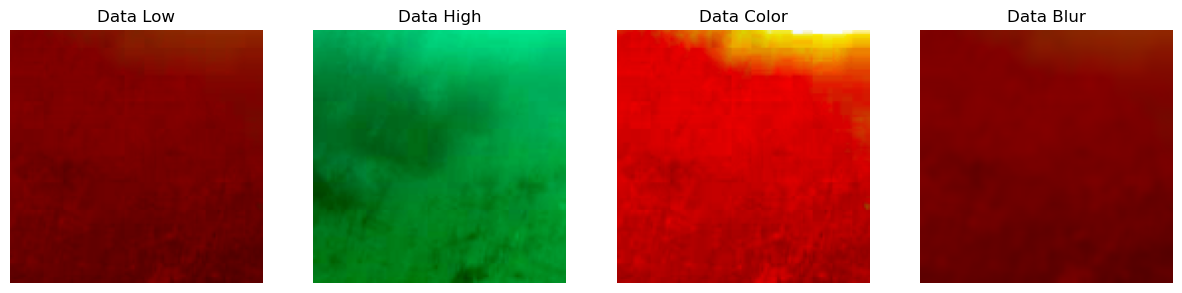

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


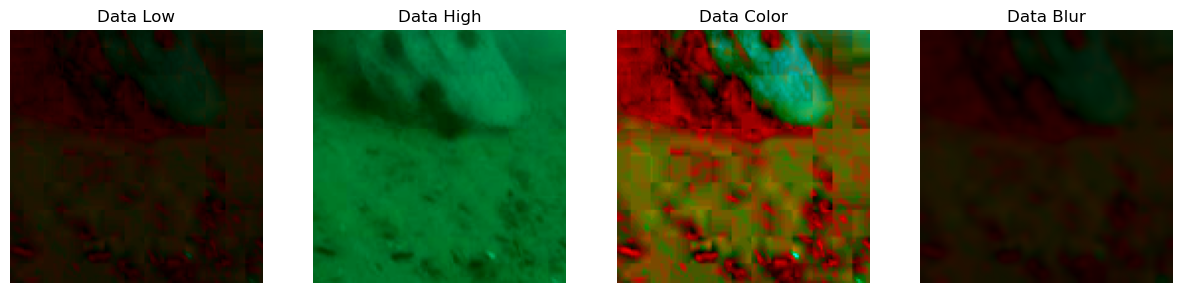

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


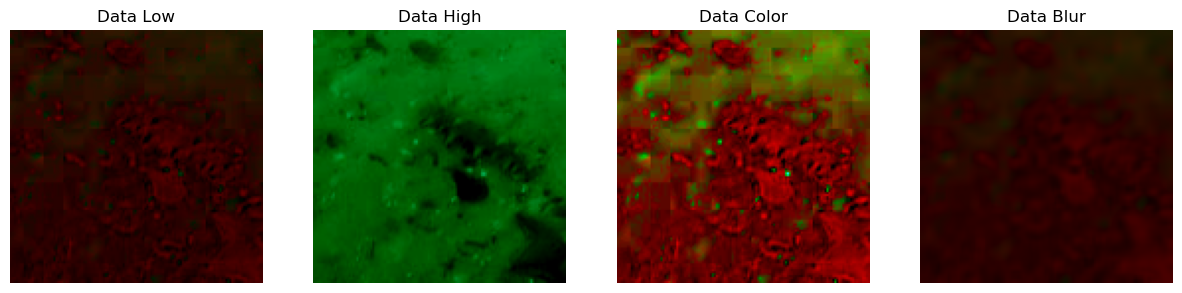

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


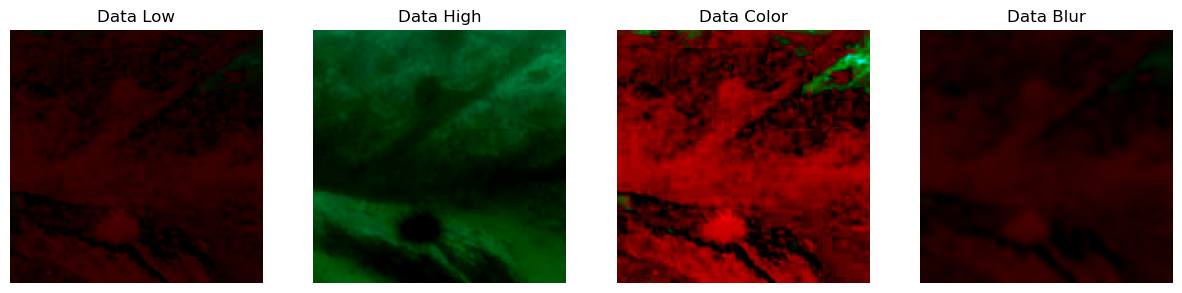

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


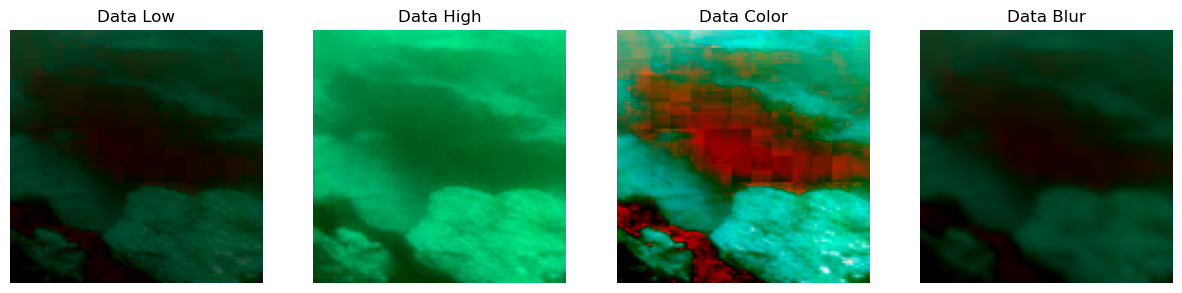

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


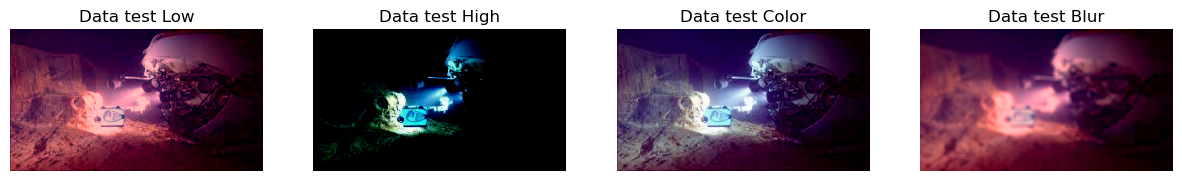

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


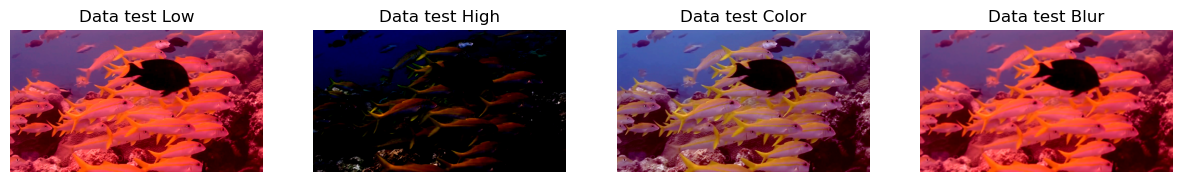

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


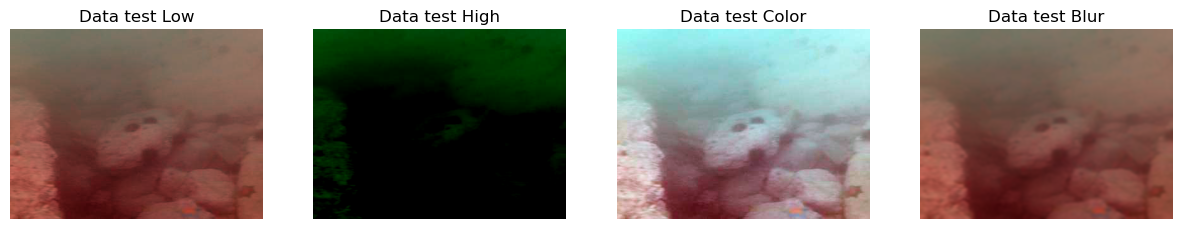

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


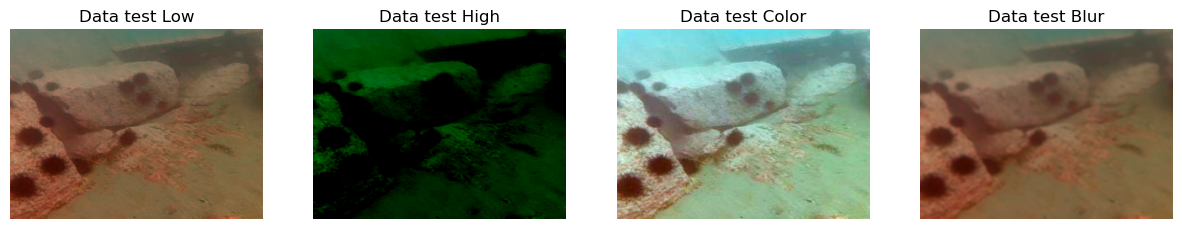

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


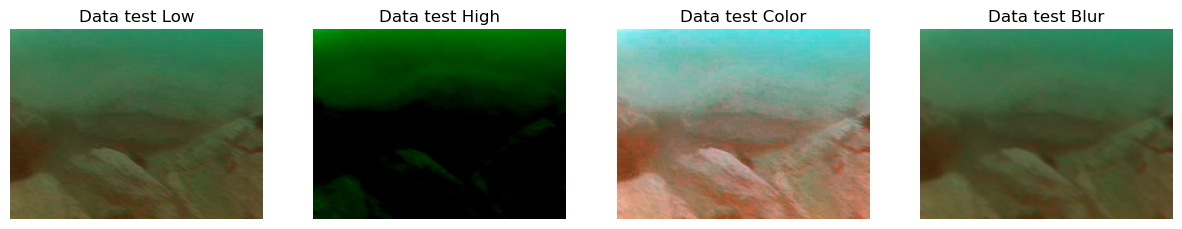

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from src.train import load_data, load_data_test
from src.split_data import load_image_paths
import matplotlib.pyplot as plt
import numpy as np
import torch

def train_dataloader(dataloader, num_images=5):
    # Itera sobre o DataLoader 
    for batch_idx, (data_low, data_high, data_color, data_blur) in enumerate(dataloader):
        if batch_idx >= num_images:
            break
        # Plotagem das imagens
        #Convertendo tensores para NumPy arrays para plotagem
        image_low = np.transpose(data_low.detach().cpu().numpy(), (1, 2, 0))
        image_high = np.transpose(data_high.detach().cpu().numpy(), (1, 2, 0))
        image_color = np.transpose(data_color.detach().cpu().numpy(), (1, 2, 0))
        image_blur = np.transpose(data_blur.detach().cpu().numpy(), (1, 2, 0))
                # Transpose and print shapes
        # print(f"""  data_low: {data_low.shape}
        #                 data_high: {data_high.shape}
        #                 data_color: {data_color.shape}
        #                 data_blur: {data_blur.shape}
        #                 image_low: {image_low.shape}
        #                 image_high: {image_high.shape}
        #                 image_color: {image_color.shape}
        #                 image_blur: {image_blur.shape}
        # """)
        # Mostrando as imagens
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(image_low)
        plt.title("Data Low")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(image_high)
        plt.title("Data High")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(image_color)
        plt.title("Data Color")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(image_blur)
        plt.title("Data Blur")
        plt.axis('off')

        plt.show()
def test_dataloader(dataloader, num_images=5):
    # Itera sobre o DataLoader 
    for batch_idx, (data_low, data_high, data_color, data_blur, img) in enumerate(dataloader):
        if batch_idx >= num_images:
            break
        # Plotagem das imagens
        #Convertendo tensores para NumPy arrays para plotagem
        image_low = np.transpose(data_low.detach().cpu().numpy(), (1, 2, 0))
        image_high = np.transpose(data_high.detach().cpu().numpy(), (1, 2, 0))
        image_color = np.transpose(data_color.detach().cpu().numpy(), (1, 2, 0))
        image_blur = np.transpose(data_blur.detach().cpu().numpy(), (1, 2, 0))

                # Transpose and print shapes
        # print(f"""  data_low: {data_low.shape}
        #                 data_high: {data_high.shape}
        #                 data_color: {data_color.shape}
        #                 data_blur: {data_blur.shape}
        #                 image_low: {image_low.shape}
        #                 image_high: {image_high.shape}
        #                 image_color: {image_color.shape}
        #                 image_blur: {image_blur.shape}
        # """)
        # Mostrando as imagens
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(image_low)
        plt.title("Data test Low")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(image_high)
        plt.title("Data test High")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(image_color)
        plt.title("Data test Color")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(image_blur)
        plt.title("Data test Blur")
        plt.axis('off')

        plt.show()


# Exemplo de uso:
datapath_train,datapath_test = load_image_paths(dataset_path="data/UDWdata/",dataset="all")
train_loader=load_data(datapath_train, datapath_train)
test_loader = load_data_test(datapath_test,datapath_test)
# Suponha que você tenha um DataLoader chamado 'train_loader' com batch_size=4
train_dataloader(train_loader, num_images=5)
test_dataloader(test_loader, num_images=5)


### Checando erro do canal alpha nas imagens do dataset

In [3]:
from src.split_data import check_alpha_channel
c = check_alpha_channel("data/UDWdata/RUIE/UIQS/train/A_23.jpg")
c = check_alpha_channel("data/UDWdata/UIEB/train/32_img_.png")


Antes de se transformar:  (300, 400, 3) data/UDWdata/RUIE/UIQS/train/A_23.jpg
transformada : (300, 400, 4)
Antes de se transformar:  (801, 1280, 3) data/UDWdata/UIEB/train/32_img_.png
transformada : (801, 1280, 4)


### Calculando a media e o desvio padrao para normalização do dataset

In [5]:
from loss import DarkChannelPriorLoss, lab_Loss, lch_Loss
import torch
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
from src.split_data import load_image_paths
import random
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import numpy as np

class load_data(data.Dataset):
    def __init__(self, input_data_low, input_data_high):
        self.input_data_low = input_data_low
        self.input_data_high = input_data_high
        print("Total training examples:", len(self.input_data_high))
        self.transform=A.Compose(
            [
                A. Resize (height=256, width=256),
                # A.RandomCrop(height=128, width=128),
                # A.HorizontalFlip(p=0.5),
                # A.VerticalFlip(p=0.5),
                ToTensorV2()
            ]
        )


    def __len__(self):  
        return len(self.input_data_low)

    def __getitem__(self, idx):
        seed = torch.random.seed()
        data_low = cv2.imread(self.input_data_low[idx])

        ###
        #data_low = check_alpha_channel(self.input_data_low[idx])
        ###

        #data_low = cv2.convertScaleAbs(data_low, alpha=1.0, beta=-random.randint(90, 150)) #modificação para ajuste automatico de brilho para datalow

        data_low=data_low[:,:,::-1].copy()# bgr2rgb
        random.seed(1)
        data_low=data_low/255.0

        #data_low=np.power(data_low,0.25)
        data_low = self.transform(image=data_low)["image"]
        #mean and var of lol training dataset. If you change dataset, please change mean and var.
        # mean=torch.tensor([0.4350, 0.4445, 0.4086])  
        # var=torch.tensor([0.0193, 0.0134, 0.0199])
        # data_low=(data_low-mean.view(3,1,1))/var.view(3,1,1)
        # data_low=data_low/20



        return data_low
# Defina as transformações necessárias para as imagens
transform = transforms.Compose([
    transforms.ToTensor()
])

# Carregue o dataset
datapath_train = load_image_paths(dataset_path="data/UDWdata/", dataset="all")[0]
train_loader=load_data(datapath_train, datapath_train)
# Inicialize DataLoader
dataloader = DataLoader(train_loader, batch_size=32, shuffle=False, num_workers=4)

# Inicialize variáveis de acumulação
mean = torch.zeros(3)
mean_square = torch.zeros(3)
total_pixels = 0
d = DarkChannelPriorLoss(5)
lab = lab_Loss()
lch = lch_Loss()
# Itere pelo dataset
for images in dataloader:
    #print(images)
    # Obtenha o número de pixels em um lote
    num_pixels = images.size(0) * images.size(2) * images.size(3)
    total_pixels += num_pixels
    
    # Acumule as somas dos canais de cor
    mean += images.sum(dim=[0, 2, 3])
    mean_square += (images ** 2).sum(dim=[0, 2, 3])
    print(d(images).item(),lab(images,images).item(), lch(images,images).item())

# Calcule a média dos canais de cor
mean /= total_pixels

# Calcule a variância dos canais de cor
var = (mean_square / total_pixels) - (mean ** 2)

print(f'Média dos canais de cor: {mean}')
print(f'Variância dos canais de cor: {var}')

# Total training examples: 6130
##RGB
# Média dos canais de cor: tensor([0.2255, 0.4897, 0.4174])
# Variância dos canais de cor: tensor([0.0259, 0.0338, 0.0383])
##BGR
# Média dos canais de cor: tensor([0.4174, 0.4897, 0.2255])
# Variância dos canais de cor: tensor([0.0383, 0.0338, 0.0259])

Total training examples: 4904
0.0427531223671109 592.9052759359463 0.15441120076463727
0.04972842347388175 502.0260096723279 0.14278722162646623
0.05086723776424633 526.6960628026533 0.15645240904491342
0.0403073179955576 557.6602849450692 0.14388828297187964
0.03034063601026348 539.4024386467903 0.15460928963090742
0.0428984099743413 523.5363619599646 0.14900928605655023


KeyboardInterrupt: 

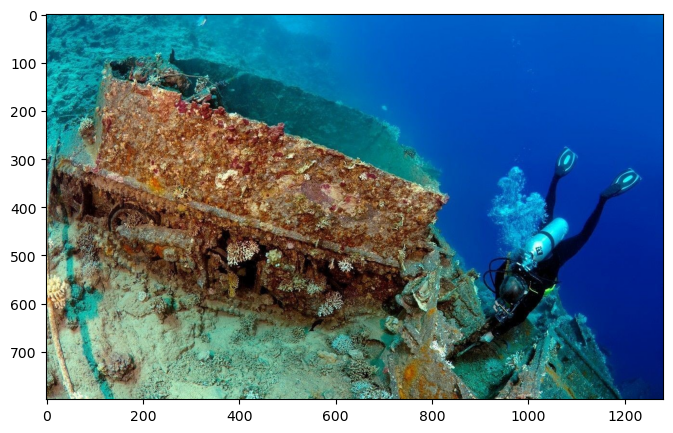

uiqm: 1.095029165882547, uciqe: 34.6030654099484


In [5]:
###MEtricas
from Metrics.metrics import * 
import matplotlib.pyplot as plt

# result_path = sys.argv[1]

# result_dirs = os.listdir(result_path)

# sumuiqm, sumuciqe = 0.,0.

# N=0
# for imgdir in result_dirs:
#     if '.png' in imgdir:
#         #corrected image
#         corrected = io.imread(os.path.join(result_path,imgdir))

#         uiqm,uciqe = nmetrics(corrected)

#         sumuiqm += uiqm
#         sumuciqe += uciqe
#         N +=1

#         with open(os.path.join(result_path,'metrics.txt'), 'a') as f:
#             f.write('{}: uiqm={} uciqe={}\n'.format(imgdir,uiqm,uciqe))

# muiqm = sumuiqm/N
# muciqe = sumuciqe/N

corrected = io.imread("./data/UDWdata/UIEB/train/2_img_.png")
plt.figure(figsize=(15, 5))
plt.imshow(corrected)
plt.show()

uiqm,uciqe = nmetrics(corrected)
print(f"uiqm: {uiqm}, uciqe: {uciqe}")

# Passos que ainda tem de ser tomados
## Normalização

[x] Encontrar valores para normalizacao do dataset.

[x] Normalizar o dataset de acordo com os valores encontrados.

[x] Testar o batch e conferir se funcionou.

[x] Erro de corres avermelhadas na correção da imagem
    
## Metricas

[x] Arrumar a função de metricas

## Teste e treino e losss

[x] Criar a rotina de teste juntamente com a de treino e carregar os dados da forma como tem de ser feita para testar de 100 em 100 epocas e salvar o checkpoint correspondente. Salvar os dados das loss e da metricas no wandb

[ ] Criar organização para comparar as loss combinadas e sobre a combinação das losses nesse contexto

[ ] as funcoes de perda, lab e lch e jdark(darkchannel) nao funcionam como deveriam devido as transformacoes realizadas ao carregar as imagens geradas. De forma que é necessário um estudo mais apurado do funcionamento delas. O darkchannel por exemplo nao poderia receber valores com pixels negativos, teriam de estar normalizados, entretanto devido a algumas transformacoes nos dados de entrada ele recebe pixels negativos. o lab e lch apresentam valores muito grandes e sua matematica deve ser revisada.



### Arrumar as losses

[x] analisar os valores das los lch e lab para conferir sua verossimilhança com a aplicação proposta

[x] analisar as outras loss e quais devem ser aplciadas

[x] separar as losses perceptuais na aplicação necessária


### Ajustar as transformadas para imagem de alta luminosidade e de baixa luminosidade usando o opencv pelo processamento usado no codigo 

[x] testar batch com as novas transformações de luminosidade. 

[x] testar intervalo de range 50 a 100 e -50 a -100

[X] Testar a rede nos pcs da B06 pra ver se roda -> Nao roda

[ ] Conferir o erro que apareceu no treinamento das ultimas imagens sobre canal de cor

## Comparações

[ ] Gerar comparação dos metodos estados da arte

[ ] separar os metodos que serão utilizados

[ ] Encontrar repositórios com os metodos usados

[ ] Utilizar dataset gerado com os repos selecionados e coneguir a rede treinada e novas imagens para comparação

[ ] Utilizar a metrica de comparação para avaliar as imagens destes diretorios
    

 

## Inference

In [5]:
!python3 main.py

Namespace(dataset='all', model='standart', dataset_path='./data/UDWdata/', state='train', pretrained_path=None, output_path='./output/', DDP=False, epoch=10001, batch_size=16, T=1000, channel=128, channel_mult=[1, 2, 3, 4], attn=[2], num_res_blocks=2, dropout=0.15, lr=5e-05, multiplier=2.0, beta_1=0.0001, beta_T=0.02, img_size=32, grad_clip=1.0, device='cuda', device_list=[0], ddim=True, unconditional_guidance_scale=1, ddim_step=100)
Total training examples: 4904
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in